## 1. Introduction  
This is my first kernel at Kaggle. I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using an voting procedure.
  
This script follows three main parts:
  
Feature analysis  
Feature engineering  
Modeling

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

ModuleNotFoundError: No module named 'matplotlib'

## 2. Load and check data¶
### 2.1 Load data

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

KeyError: 'PassengerId'

### 2.2 Outlier detection

In [106]:
# 아웃라이어 확인
def detect_outliers(df,n,features):
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

### 이상치 처리 이유 및 방법
예측(특히 회귀 문제)에서 이상치는 결과에 큰 영향을 줄 수 있기 때문에 이를 처리하기로 결정했다.

이상치 탐지를 위해 Tukey 방법(Tukey JW., 1977)을 사용했으며, 이는 **1사분위수(Q1)와 3사분위수(Q3) 사이의 범위(IQR)**를 기준으로 한다.  
IQR을 기준으로 (Q1 - 이상치 범위) ~ (Q3 + 이상치 범위) 바깥에 있는 값을 이상치로 간주한다.

Age, SibSp, Parch, Fare와 같은 수치형 변수에서 이상치를 탐지했으며, 두 개 이상의 변수에서 이상치로 판단되는 행을 최종 이상치로 간주하였다.

In [107]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [108]:
# 이상치 제거
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [109]:
train_len = len(train) # 881
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [110]:
dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


📌 axis 매개변수의 의미  
axis=0	행	위에서 아래로 붙임 (행 추가)  
axis=1	열	왼쪽에서 오른쪽으로 붙임 (열 추가)

🔄 데이터 결합 이유  
카테고리형 변환 과정에서 동일한 개수의 특성(피처)을 갖기 위해  
train 데이터셋과 test 데이터셋을 하나로 결합했다.

### 2.4 check for null and missing values

In [111]:
dataset = dataset.fillna(np.nan)
dataset.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age, Cabin 특성에는 상당한 결측치가 존재한다.  
Survived 특성의 결측값은 test 데이터셋을 병합하면서 발생한 것이다.  
왜냐하면 test 데이터셋에는 원래 Survived 열이 존재하지 않기 때문에  
합치는 과정에서 결측치로 채워진 것으로 생각해 볼 수 있다.

In [112]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [113]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [114]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [115]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [116]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 3. Feature analysis¶
### 3.1 Numerical values

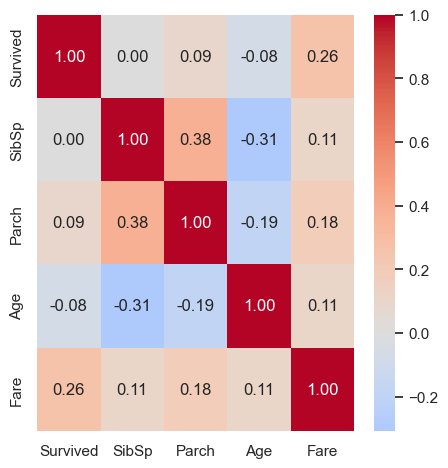

<Figure size 640x480 with 0 Axes>

In [117]:
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True,
                fmt = ".2f", cmap = "coolwarm", center=0) # center=0 양수,음수 구분 안 됨 문제 해결
plt.figure() # y축 중복 출력 문제 해결
plt.show()

🔍 생존 확률과의 상관관계 분석  
Fare(요금) 변수만이 생존 확률과 유의미한 상관관계를 가지는 것으로 보인다.

하지만 다른 변수들이 무의미하다는 뜻은 아니다.
이러한 변수들 안의 **특정 하위 집단(subpopulation)**이 생존과 관련이 있을 수 있다.

이를 판단하려면, 이 변수들을 더 세부적으로 탐색해볼 필요가 있다.

### SibSP

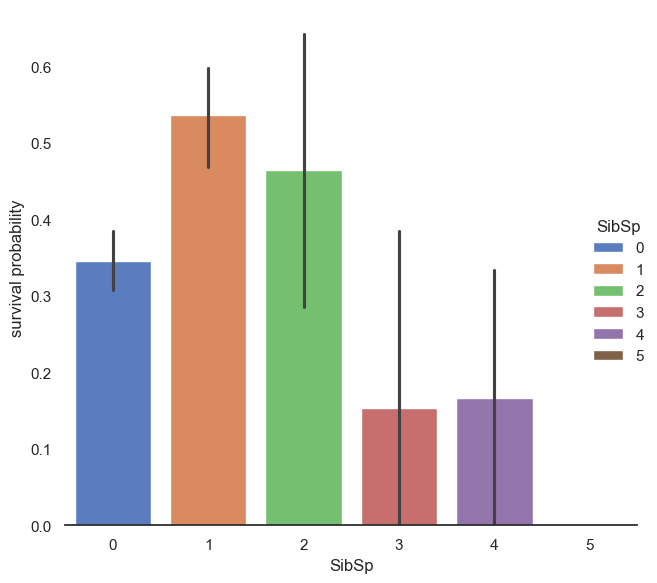

In [118]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html
g = sns.catplot(x="SibSp",y="Survived",hue="SibSp",data=train,kind="bar", height = 6 , 
palette= "muted")
# hue 파라미터 넣어야 warning 사라짐

g.despine(left=True)
g = g.set_ylabels("survival probability")

plt.tight_layout()
plt.show()

📝 Feature Engineering 관련 통찰
형제자매/배우자(SibSp)가 많은 승객일수록 생존 확률이 낮은 경향이 있는 것으로 보인다.
  
반면, 혼자 탑승했거나(SibSp = 0), 두 명 이하의 가족과 함께 탑승한 승객들(SibSp = 1 또는 2)은 생존 확률이 더 높은 경향이 있다.
  
이 관찰 결과는 흥미로우며, 이러한 범주를 설명하는 새로운 피처(feature)를 고려할 수 있다.

### Parch

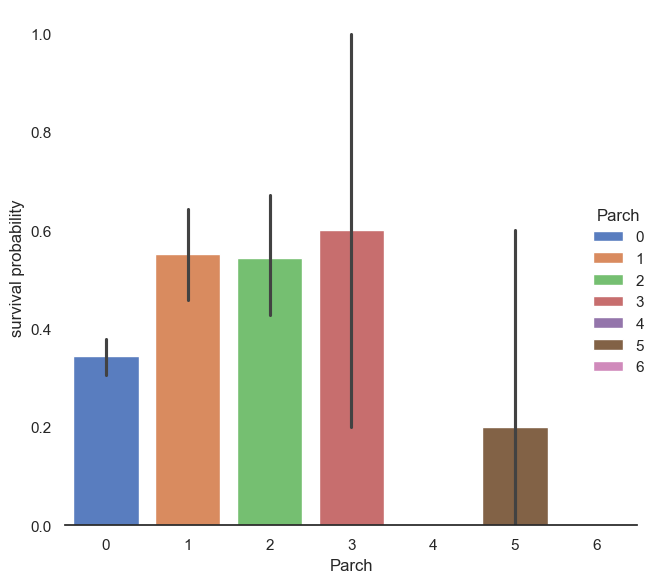

In [119]:
g = sns.catplot(x="Parch", y="Survived", hue="Parch", data=train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

plt.tight_layout()
plt.show()

형제 자매가 많을수록 생존 확률이 낮다.  
반면, 혼자 탑승하거나 두 명 이하의 가족과 함께 탑승한 승객들의 생존 확률이 더 높다.  

### Age

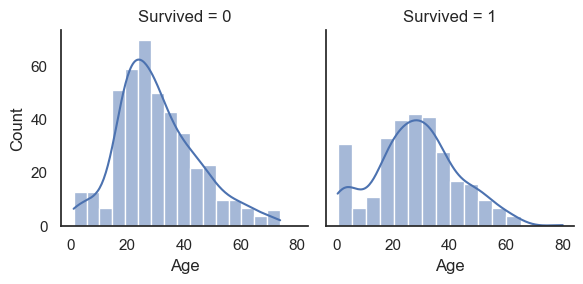

In [120]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age", kde=True) # distplot -> histplot으로 변경
# kde=True 라인 그리기

plt.tight_layout()
plt.show()

나이 분포는 꼬리가 긴 분포처럼 보이며, 아마도 정규분포(가우시안 분포)일 수 있다.

생존한 승객과 비생존한 승객의 나이 분포는 동일하지 않다는 것을 알 수 있다.. 특히 어린 승객들이 생존한 구간에서 뚜렷한 봉우리가 나타난다. 또한 60세에서 80세 사이의 승객은 생존율이 낮다.

따라서 나이(Age)가 생존 여부(Survived)와 직접적으로 상관관계가 없을 수 있지만, 특정 나이대의 승객들은 생존할 확률이 더 높거나 낮은 경향이 있다는 것을 알 수 있다.

특히 매우 어린 승객들은 생존할 확률이 더 높은 것으로 보인다.

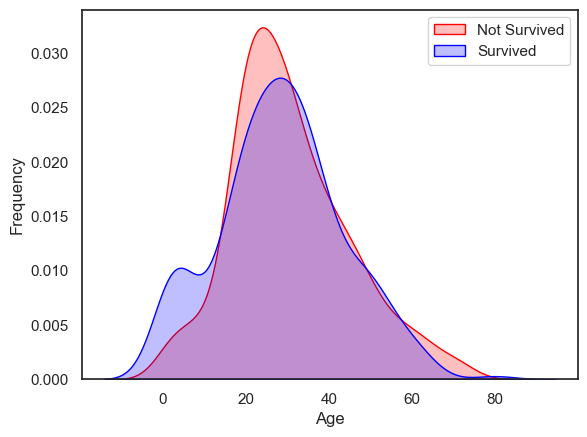

In [121]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", fill= True)
# shade -> fill

g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

plt.show()

### Fare

In [122]:
dataset["Fare"].isna().sum()

1

In [123]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

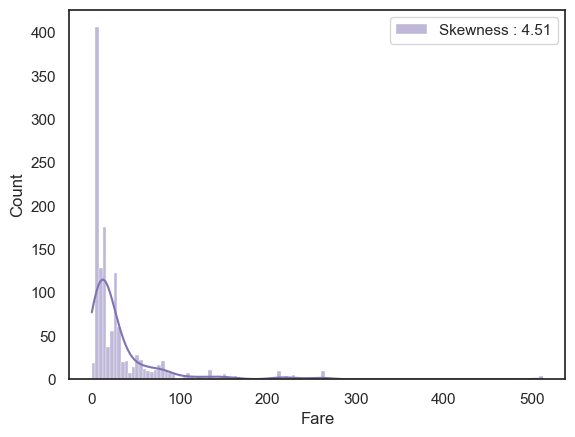

In [124]:
g = sns.histplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()), kde=True)
g = g.legend(loc="best")

plt.show()

🎯 요금(Fare) 분포는 매우 왜곡되어 있다  
이는 모델에서 매우 큰 값들이 과도한 영향을 미치게 만들 수 있으며, 심지어 스케일링을 하더라도 그 영향이 줄어들지 않을 수 있다.

이러한 경우에는 로그 함수(log function) 를 사용하여 왜곡(skewness) 을 줄이는 것이 더 좋다.

In [125]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

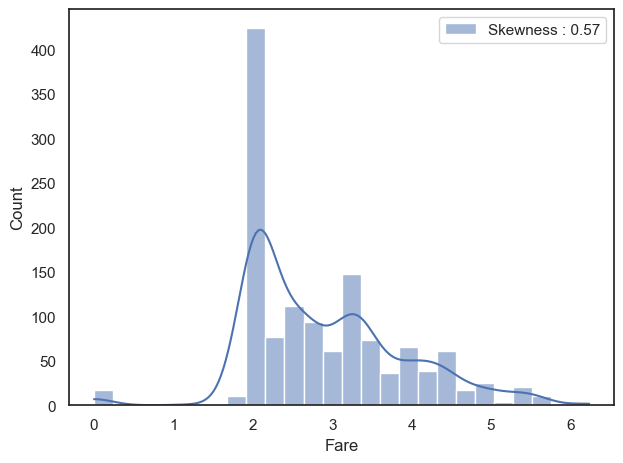

In [130]:
g = sns.histplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()), kde=True)
# distplot -> histplot, kde=True(라인 만들기)
g = g.legend(loc="best")

plt.tight_layout()
plt.show()

### 3.2 Categorical values
### Sex

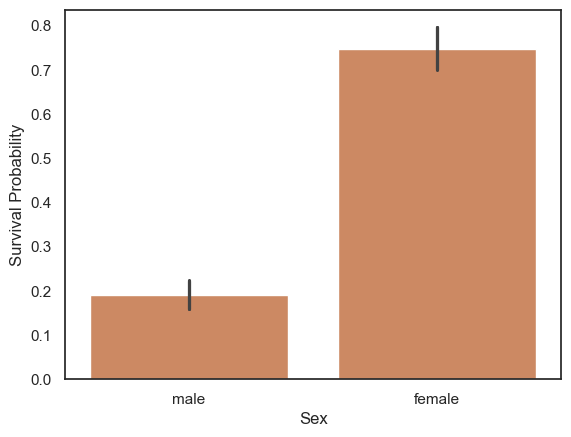

In [132]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

plt.show()

In [140]:
train[["Sex","Survived"]].groupby('Sex').mean()
# 반환값 dataframe

,Survived
Sex,
female,0.747573
male,0.190559


In [144]:
train.groupby('Sex')['Survived'].mean()
# 반환값 series

Sex
female    0.747573
male      0.190559
Name: Survived, dtype: float64

확연히 남성은 여성보다 생존 확률이 적다.  
따라서 성별은 생존 예측에 중요한 역할을 할 것으로 본다.  

### Pclass

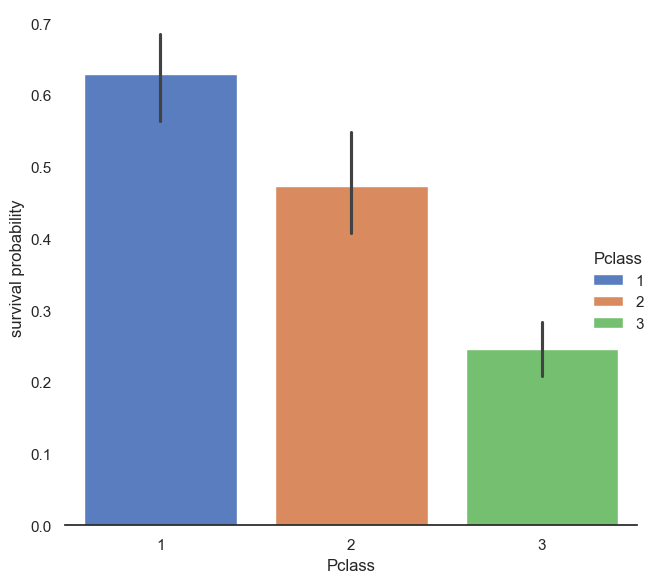

In [151]:
g = sns.catplot(x="Pclass",y="Survived",hue="Pclass",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

plt.tight_layout()
plt.show()

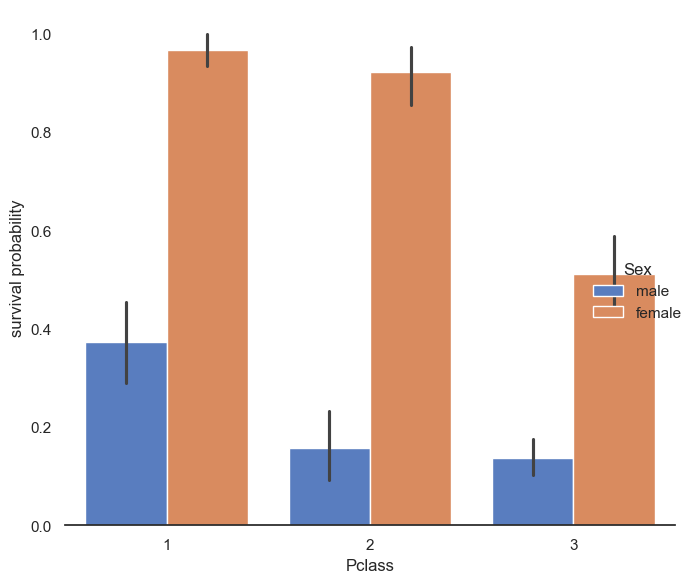

In [155]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train,
                hue_order=["male", "female"],
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

plt.tight_layout()
plt.show()

Pclass1에 탑승한 승객이 생존 확률이 가장 높다.

### Embarked

In [156]:
dataset['Embarked'].isna().sum()

2

In [159]:
dataset['Embarked'].value_counts()

Embarked
S    904
C    270
Q    123
Name: count, dtype: int64

In [162]:
dataset[dataset['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
60,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,4.382027,B28,NaN
821,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,4.382027,B28,NaN


In [170]:
dataset.groupby('Pclass')['Fare'].mean()

Pclass
1    4.095511
2    2.872347
3    2.360554
Name: Fare, dtype: float64

 "Pclass 중 가장 많이 등장하는 값인 'S'로 결측치를 채운다."  
`Since we have two missing values , i decided to fill them with the most fequent value of "Embarked" (S).` 
    
결측치가 있는 데이터를 확인한 결과, 해당 승객의 Fare 값은 4.38달러였다.  
이후 Pclass별로 Fare의 평균을 계산해보니, 4달러대의 Fare를 가진 승객은 'S' 클래스에만 해당하는 것으로 나타났다.  
  
빈도수만을 고려해 결측치를 채우는 것은 적절하지 않지만, 내가 분석한 과정에서 'S' 클래스가 가장 합리적인 선택임을 확인할 수 있었다.  

4. Filling missing Values

In [4]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

NameError: name 'sns' is not defined

In [ ]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [ ]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

In [2]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

NameError: name 'dataset' is not defined

In [3]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

NameError: name 'sns' is not defined